In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-performance/data.csv


# 1. Setup and Data Loading

In [56]:
import pandas as pd

# Read data from local CSV
raw_data = pd.read_csv(
    "/kaggle/input/students-performance/data.csv",
    sep=';'
)

# Define target and feature types
target_col = 'Target'
categorical_features = [
    'Marital status','Application mode','Course','Daytime/evening attendance\t',
    'Previous qualification','Nacionality','Mother\'s qualification','Father\'s qualification',
    'Mother\'s occupation','Father\'s occupation','Displaced','Educational special needs',
    'Debtor','Tuition fees up to date','Gender','Scholarship holder','International'
]
numeric_features = [col for col in raw_data.columns if col not in categorical_features + [target_col]]

print(f"Loaded data with shape: {raw_data.shape}")
raw_data.head()


Loaded data with shape: (4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# 2. Exploratory Data Analysis

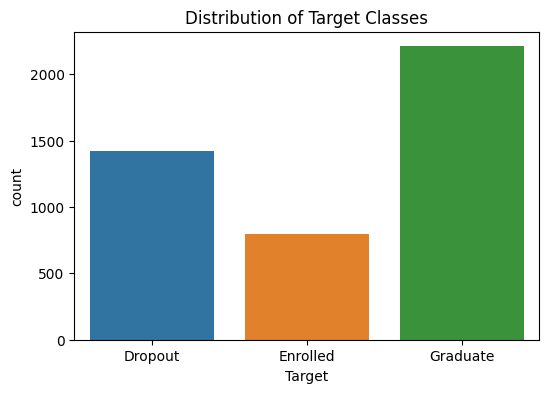

Missing values by column:
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                    

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

order = ["Dropout", "Enrolled", "Graduate"]
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=raw_data, order=order)
plt.title('Distribution of Target Classes')
plt.show()

print("Missing values by column:")
print(raw_data.isnull().sum())

In [58]:
target_map = {label: idx for idx, label in enumerate(order)}
y_num = raw_data[target_col].map(target_map)

df_numeric = raw_data[numeric_features]
corr_vals = df_numeric.apply(lambda col: col.corr(y_num))
corr_df = corr_vals.rename('corr').to_frame()
corr_df['abs_corr'] = corr_df['corr'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False)

print("Top 10 features by absolute correlation:")
print(corr_df.head(10))

corr_df.to_csv('feature_target_correlation_sorted.csv', index=True)

Top 10 features by absolute correlation:
                                                    corr  abs_corr
Curricular units 2nd sem (approved)             0.624157  0.624157
Curricular units 2nd sem (grade)                0.566827  0.566827
Curricular units 1st sem (approved)             0.529123  0.529123
Curricular units 1st sem (grade)                0.485207  0.485207
Age at enrollment                              -0.243438  0.243438
Curricular units 2nd sem (enrolled)             0.175847  0.175847
Curricular units 1st sem (enrolled)             0.155974  0.155974
Admission grade                                 0.120889  0.120889
Previous qualification (grade)                  0.103764  0.103764
Curricular units 2nd sem (without evaluations) -0.094028  0.094028


# 3. Data Preprocessing

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = raw_data.drop(columns=[target_col])
y = raw_data[target_col].map(target_map)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# 4. Model Training and Evaluation

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'XGBoost': XGBClassifier()
}

best_acc = 0
best_model = None
for name, model in models.items():
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.3f}")
    print(classification_report(y_test, preds, target_names=order))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("-----")
    if acc > best_acc:
        best_acc = acc
        best_model = model

print(f"Best model: {best_model.__class__.__name__} (Accuracy: {best_acc:.3f})")


Logistic Regression Accuracy: 0.768
              precision    recall  f1-score   support

     Dropout       0.78      0.75      0.77       284
    Enrolled       0.55      0.39      0.46       159
    Graduate       0.81      0.91      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.69      0.69       885
weighted avg       0.75      0.77      0.76       885

Confusion Matrix:
 [[214  31  39]
 [ 41  62  56]
 [ 18  20 404]]
-----
SVC Accuracy: 0.764
              precision    recall  f1-score   support

     Dropout       0.81      0.72      0.76       284
    Enrolled       0.53      0.37      0.44       159
    Graduate       0.79      0.93      0.86       442

    accuracy                           0.76       885
   macro avg       0.71      0.68      0.69       885
weighted avg       0.75      0.76      0.75       885

Confusion Matrix:
 [[205  36  43]
 [ 35  59  65]
 [ 13  17 412]]
-----
XGBoost Accuracy: 0.765
              pr

# 5. Save Best Model and Scaler

In [61]:
import joblib
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(target_map, 'target_map.pkl')
print("Artifacts saved: model, preprocessor, target_map.")


Artifacts saved: model, preprocessor, target_map.
